In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier

from collections import Counter
import pickle
import _pickle as cPickle
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from lightgbm import log_evaluation
from optuna.trial import Trial
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import lightgbm
pd.set_option('use_inf_as_na', True)
from collections import Counter
import pickle

import optuna
from optuna.trial import Trial
import optuna.integration.lightgbm as lgb


from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from lightgbm import log_evaluation
import sklearn.datasets
from sklearn.model_selection import train_test_split

from functools import partial

scaler = StandardScaler()

In [2]:
with open(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/course_files_export/Lecture 13, Feb 20, 2024/Random Forest Parameters/shap_features.pkl','rb') as f:
    shap_features_RF = cPickle.load(f)

In [3]:
shap_features_RF

[Index(['apq', 'cash_ratioq', 'cf_yield', 'oepsxy', 'rect_actq', 'prccq',
        'cheq', 'roeq', 'book_value_yield', 'niq', 'lagseq4', 'dlttq', 'cfmq',
        'txditcq', 'ibcomy'],
       dtype='object'),
 Index(['cfmq', 'epspi12', 'oeps12', 'saleq', 'epsfi12', 'curr_ratioq',
        'csh12q', 'market_cap', 'dvpspq', 'cfo-per-share', 'capeiq',
        'fcf_yield', 'pe_incq', 'fcf_csfhdq', 'yearly_sales', 'oancfy',
        'pay_turnq', 'lagicapt4', 'oancfy_q', 'prccq', 'lagppent_alt4',
        'rd_saleq', 'cshfdq', 'beq', 'apq', 'cshprq', 'at_turnq', 'cf_yield',
        'quick_ratioq', 'pe_exiq', 'dpcq', 'epsx12', 'actq', 'cash_debtq',
        'cash_ltq', 'seq4', 'epspxq', 'oibdpy', 'ibadj12', 'pcfq', 'dltry',
        'accrualq', 'ibq', 'at5', 'cshiq'],
       dtype='object'),
 Index(['oepsxq', 'oeps12', 'yearly_sales', 'ibadj12', 'oiadpq',
        'aftret_equityq', 'fqtr_4', 'atq', 'roeq', 'oancfy_q', 'cogsq', 'evmq',
        'opepsq', 'ceqq', 'lagseq4', 'pe_op_basicq', 'lagppent4', 

In [4]:
with open(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/course_files_export/Lecture 13, Feb 20, 2024/Gradient Boosting Parameters/shap_features_gb_clf_01.pkl','rb') as g:
    shap_features_GB = cPickle.load(g)

In [5]:
shap_features_GB

[Index(['prccq', 'evmq', 'market_cap', 'oancfy_q', 'capeiq', 'opmbdq',
        'lagicapt4', 'int_debtq', 'pay_turnq', 'dlttq',
        ...
        'csh12q', 'be4', 'spcsrc_B', 'atq', 'at5', 'miiq', 'at4',
        'book_value_per_share', 'pe_incq', 'ceq4'],
       dtype='object', length=166),
 Index(['curr_ratioq', 'fcf_csfhdq', 'lagicapt4', 'cash_conversionq',
        'epsfi12'],
       dtype='object'),
 Index(['market_cap', 'capeiq', 'oancfy_q', 'pay_turnq', 'opmbdq', 'fcf_yield',
        'debt_assetsq', 'evmq', 'apq', 'cheq', 'cash_conversionq', 'prccq',
        'ibadj12', 'cfmq', 'rect_turnq', 'xrdy', 'int_debtq', 'rectq',
        'efftaxq', 'lt_ppentq', 'txpq', 'inv_turnq', 'fqtr_2', 'capxq',
        'cf_yield', 'xsgay', 'txpdy', 'rd_saleq', 'oepsxy', 'dltisy', 'cshfdq',
        'invtq', 'pretret_noaq', 'dltt_beq', 'lctq4', 'lagicapt4', 'aftret_eqq',
        'aftret_invcapxq', 'quick_ratioq', 'debt_atq', 'at_turnq', 'dvq', 'at4',
        'chechy', 'xinty', 'txditcq', 'book_value_yi

In [6]:
dic_RF={}
for features in shap_features_RF:
    for i in features:
      if i in dic_RF.keys():
          dic_RF[i]+=1
      else:
          dic_RF[i]=1

dic_GB={}
for features in shap_features_GB:
    for i in features:
      if i in dic_GB.keys():
          dic_GB[i]+=1
      else:
          dic_GB[i]=1

dic_RF=sorted(dic_RF.items(),key=lambda x:x[1],reverse=True)

selected_features_RF=[i[0] for i in dic_RF[:10]]
selected_features_RF

['fcf_yield',
 'cf_yield',
 'oancfy',
 'oancfy_q',
 'fcf_csfhdq',
 'lt_ppentq',
 'evmq',
 'dprq',
 'oepsxy',
 'dvpspq']

In [7]:
dic_GB=sorted(dic_GB.items(),key=lambda x:x[1],reverse=True)

selected_features_GB=[i[0] for i in dic_GB[:10]]
selected_features_GB

['fcf_yield',
 'cf_yield',
 'evmq',
 'lt_ppentq',
 'oancfy',
 'opmbdq',
 'rect_turnq',
 'rectq',
 'fcf_csfhdq',
 'oepsxy']

RF Strategy

In [8]:
raw_data = pd.read_pickle(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/course_files_export/Lecture 3, Jan 11,2024/dataset.pkl')

raw_data.head()
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0, inplace=True)

In [9]:
#label function
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:
    
        return 0

In [10]:
data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date',inplace=True)

In [11]:
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months = 3*i) for i in range(57)]
end_dates = [d + pd.DateOffset(months = 36) for d in start_dates]

In [12]:
training_frames = [data.loc[d:d+pd.DateOffset(months = 36)] for d in start_dates]
valid_frames = [data.loc[d+pd.DateOffset(months = 3):d+pd.DateOffset(months = 6)] for d in end_dates]
test_frames = [data.loc[d+pd.DateOffset(months = 9):d+pd.DateOffset(months = 12)] for d in end_dates]

In [13]:
training_data = [d.reset_index().drop
                 (['ticker', 'date',
                   'next_period_return',
                   'spy_next_period_return',
                   'rel_performance', 'pred_rel_return',
                   'return', 'cum_ret', 'spy_cum_ret'], axis=1) for d in training_frames]
valid_data = [d.reset_index().drop
              (['ticker', 'date',
                'next_period_return',
                'spy_next_period_return',
                'rel_performance', 'pred_rel_return',
                'return', 'cum_ret', 'spy_cum_ret'], axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker', 'date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance', 'pred_rel_return',
                                   'return', 'cum_ret', 'spy_cum_ret'], axis=1) for d in test_frames]

In [14]:
training_data = [d[selected_features_RF] for d in training_data]
valid_data=[d[selected_features_RF] for d in valid_data]
test_data=[d[selected_features_RF] for d in test_data]

In [15]:
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames] 

In [16]:
for i in range(len(start_dates)-1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])
        
    

In [17]:
import optuna
from optuna.trial import Trial
optuna.logging.set_verbosity(optuna.logging.FATAL)
import warnings
warnings.filterwarnings("ignore")

In [18]:
def calculate_max_drawdown(returns):
    peak = returns.max()
    drawdown = (returns - peak) / peak
    max_drawdown = drawdown.min()
    return max_drawdown

In [19]:
def max_drawdown(returns):
        local_max = [n for n in range(len(returns)-1) if ((n==0) and (returns[0] > returns[1])) or 
           ((n > 0) and  (returns[n-1]<returns[n]) and (returns[n+1]<returns[n]))] 
        
        local_min = [n for n in range(1,len(returns)) if ((n == len(returns)-1) and (returns[-1] < returns[-2])) or
                (returns[n-1]>returns[n]) and (returns[n+1]>returns[n])]
        
        def next_local_min(n):
            if [m for m in local_min if m > n]:
                return [m for m in local_min if m > n][0]
            else: return None
        
        drawdowns = [(n,next_local_min(n)) for n in local_max]
        drawdown_values = [returns[n] - returns[m] for (n,m) in drawdowns if m != None]
        if drawdown_values:
            return  np.max(drawdown_values)
        else: return 0.0

In [20]:
#this is the object to focus on the profit only
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,2,step=1)
    ada_n_estimators = trial.suggest_int('n_estimators', 30,60,step=5)
    ada_learning_rate = trial.suggest_float('learning_rate',0.2,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    accuracy = ada_clf.score(val,val_labels)
    mdd = max_drawdown(preds*val_rets.values)
    profit = (preds * val_rets).sum()
    risk =  (preds * val_rets).std()

    w1, w2, w3 = 0, 1, 0  # Example weights
    composite_score = (w1 * mdd) + (w2 * profit) - (w3 * risk)
    
    return composite_score

In [ ]:
optimal_hyperparameters = []
from functools import partial

for i in range(len(start_dates) - 1):
    study = optuna.create_study(direction="maximize")

    study.optimize(partial(objective,
                           train=training_data[i],
                           labels=training_labels[i],
                           val=valid_data[i],
                           val_labels=valid_labels[i],
                           val_rets=valid_frames[i]['next_period_return']), n_trials=25, n_jobs=-1)

    optimal_hyperparameters.append(study.best_params)
    print(study.best_params)


{'max_depth': 2, 'n_estimators': 40, 'learning_rate': 0.5}
{'max_depth': 1, 'n_estimators': 30, 'learning_rate': 0.30000000000000004}
{'max_depth': 2, 'n_estimators': 30, 'learning_rate': 0.2}
{'max_depth': 2, 'n_estimators': 60, 'learning_rate': 0.30000000000000004}
{'max_depth': 2, 'n_estimators': 40, 'learning_rate': 0.2}
{'max_depth': 2, 'n_estimators': 45, 'learning_rate': 0.5}
{'max_depth': 1, 'n_estimators': 30, 'learning_rate': 0.2}
{'max_depth': 2, 'n_estimators': 50, 'learning_rate': 0.5}
{'max_depth': 2, 'n_estimators': 60, 'learning_rate': 0.5}
{'max_depth': 1, 'n_estimators': 60, 'learning_rate': 0.2}
{'max_depth': 1, 'n_estimators': 30, 'learning_rate': 0.30000000000000004}
{'max_depth': 1, 'n_estimators': 30, 'learning_rate': 0.30000000000000004}
{'max_depth': 1, 'n_estimators': 60, 'learning_rate': 0.5}
{'max_depth': 2, 'n_estimators': 35, 'learning_rate': 0.30000000000000004}
{'max_depth': 2, 'n_estimators': 45, 'learning_rate': 0.5}
{'max_depth': 2, 'n_estimators': 35

In [ ]:
classifiers = []
for hyp_par in optimal_hyperparameters:
    max_depth = hyp_par['max_depth']
    n_estimators = hyp_par['n_estimators']
    learning_rate = hyp_par['learning_rate']
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth), n_estimators=n_estimators,
                                 learning_rate=learning_rate)
    classifiers.append(ada_clf)
for i in range(len(start_dates) - 1):
    classifiers[i].fit(training_data[i], training_labels[i])
with open(r'classifiers_ada_01.pkl', 'wb') as f:
    cPickle.dump(classifiers, f)
with open(r'classifiers_ada_01.pkl', 'rb') as f:
    classifiers = cPickle.load(f)


def adaboost_feat_importances(m, df):
    return pd.DataFrame({'cols': df.columns, 'feat_imp': m.feature_importances_}
                        ).sort_values('feat_imp', ascending=False)

In [ ]:

scalers = [StandardScaler() for i in range(len(start_dates) - 1)]

opt_training_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][selected_features_RF].values), columns=selected_features_RF) for i
    in range(len(start_dates) - 1)]
opt_valid_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][selected_features_RF].values), columns=selected_features_RF) for i
    in range(len(start_dates) - 1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][selected_features_RF].values), columns=selected_features_RF)
                 for i in range(len(start_dates) - 1)]
x = [1]
ret = []

for i in range(len(start_dates) - 1):
    classifiers[i].fit(opt_training_data[i], training_labels[i])

    preds = classifiers[i].predict(opt_test_data[i])
    profit_i = (preds * test_frames[i]['next_period_return']).sum()
    ret.append(profit_i)
    num_names = len(opt_test_data[i])
    x.append(x[i] + (x[i] / num_names) * profit_i)
SPY = pd.read_pickle(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/course_files_export/Lecture 2/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x
SPY.plot();

In [ ]:
calculate_max_drawdown(SPY['strategy'])

In [ ]:
calculate_max_drawdown(SPY['spy_cum_ret'])

In [ ]:
#this is the PL matrix
PL_data=SPY.diff()['strategy'].dropna()
PL_data.plot()

In [ ]:

strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret / strategy_std
print('Strategy Sharpe Ratio: ', strategy_sr)

In [ ]:
#this is the first strategy which only focus on profit
Strategy_1=SPY['strategy']

In [ ]:
#now we try to focus on the mdd
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,2,step=1)
    ada_n_estimators = trial.suggest_int('n_estimators', 30,80,step=5)
    ada_learning_rate = trial.suggest_float('learning_rate',0.2,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    accuracy = ada_clf.score(val,val_labels)
    mdd = max_drawdown(preds*val_rets.values)
    profit = (preds * val_rets).sum()
    risk =  (preds * val_rets).std()

    w1, w2, w3 = 0, 1, 0  # Example weights
    composite_score = (w1 * mdd) + (w2 * profit) - (w3 * risk)
    
    return mdd

In [ ]:
optimal_hyperparameters = []
from functools import partial

for i in range(len(start_dates) - 1):
    study = optuna.create_study(direction="maximize")

    study.optimize(partial(objective,
                           train=training_data[i],
                           labels=training_labels[i],
                           val=valid_data[i],
                           val_labels=valid_labels[i],
                           val_rets=valid_frames[i]['next_period_return']), n_trials=25, n_jobs=-1)

    optimal_hyperparameters.append(study.best_params)
    print(study.best_params)


In [ ]:
classifiers = []
for hyp_par in optimal_hyperparameters:
    max_depth = hyp_par['max_depth']
    n_estimators = hyp_par['n_estimators']
    learning_rate = hyp_par['learning_rate']
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth), n_estimators=n_estimators,
                                 learning_rate=learning_rate)
    classifiers.append(ada_clf)
for i in range(len(start_dates) - 1):
    classifiers[i].fit(training_data[i], training_labels[i])
with open(r'classifiers_ada_01.pkl', 'wb') as f:
    cPickle.dump(classifiers, f)
with open(r'classifiers_ada_01.pkl', 'rb') as f:
    classifiers = cPickle.load(f)


def adaboost_feat_importances(m, df):
    return pd.DataFrame({'cols': df.columns, 'feat_imp': m.feature_importances_}
                        ).sort_values('feat_imp', ascending=False)

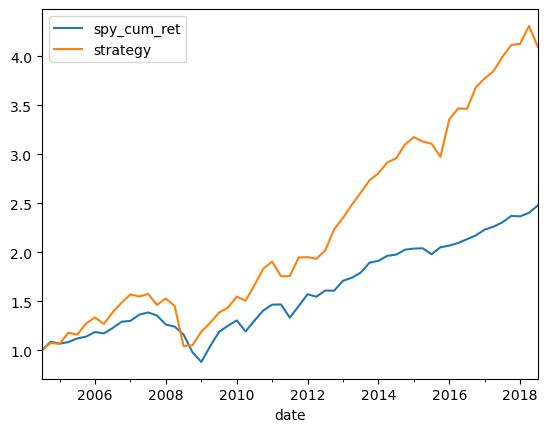

In [32]:

scalers = [StandardScaler() for i in range(len(start_dates) - 1)]

opt_training_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][selected_features_RF].values), columns=selected_features_RF) for i
    in range(len(start_dates) - 1)]
opt_valid_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][selected_features_RF].values), columns=selected_features_RF) for i
    in range(len(start_dates) - 1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][selected_features_RF].values), columns=selected_features_RF)
                 for i in range(len(start_dates) - 1)]
x = [1]
ret = []

for i in range(len(start_dates) - 1):
    classifiers[i].fit(opt_training_data[i], training_labels[i])

    preds = classifiers[i].predict(opt_test_data[i])
    profit_i = (preds * test_frames[i]['next_period_return']).sum()
    ret.append(profit_i)
    num_names = len(opt_test_data[i])
    x.append(x[i] + (x[i] / num_names) * profit_i)
SPY = pd.read_pickle(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/course_files_export/Lecture 2/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x
SPY.plot();

In [33]:
calculate_max_drawdown(SPY['strategy'])

-0.7679934483584403

In [34]:
calculate_max_drawdown(SPY['spy_cum_ret'])

-0.644186245477079

<Axes: xlabel='date'>

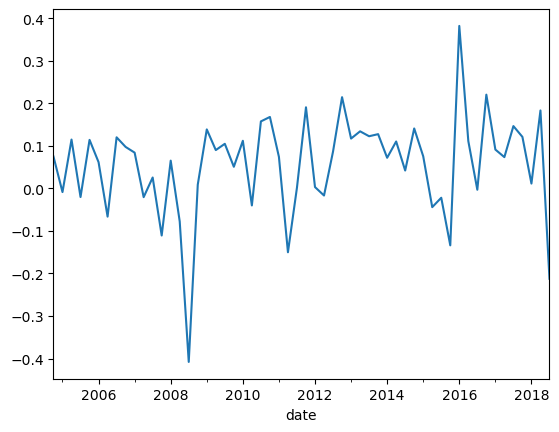

In [35]:
#this is the PL matrix
PL_data=SPY.diff()['strategy'].dropna()
PL_data.plot()

In [36]:
#this is the second strategy which only focus on mdd
Strategy_2=SPY['strategy']

In [37]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret / strategy_std
print('Strategy Sharpe Ratio: ', strategy_sr)

Strategy Sharpe Ratio:  0.46482698100354614


In [38]:
#this is the object to focus on the accuracy only
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):

    ada_m_depth = trial.suggest_int('max_depth',1,3,step=1)
    ada_n_estimators = trial.suggest_int('n_estimators', 30,80,step=5)
    ada_learning_rate = trial.suggest_float('learning_rate',0.2,0.5, step=0.1)

    
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=ada_m_depth),
                                 n_estimators=ada_n_estimators,
                                 learning_rate=ada_learning_rate,
                                 algorithm="SAMME.R")

    ada_clf.fit(train,labels)
    preds = ada_clf.predict(val)
    accuracy = ada_clf.score(val,val_labels)
    mdd = max_drawdown(preds*val_rets.values)
    profit = (preds * val_rets).sum()
    risk =  (preds * val_rets).std()

    w1, w2, w3 = 0, 1, 0  # Example weights
    composite_score = (w1 * mdd) + (w2 * profit) - (w3 * risk)
    
    return accuracy

In [39]:
optimal_hyperparameters = []
from functools import partial

for i in range(len(start_dates) - 1):
    study = optuna.create_study(direction="maximize")

    study.optimize(partial(objective,
                           train=training_data[i],
                           labels=training_labels[i],
                           val=valid_data[i],
                           val_labels=valid_labels[i],
                           val_rets=valid_frames[i]['next_period_return']), n_trials=25, n_jobs=-1)

    optimal_hyperparameters.append(study.best_params)
    print(study.best_params)


{'max_depth': 3, 'n_estimators': 40, 'learning_rate': 0.30000000000000004}
{'max_depth': 2, 'n_estimators': 30, 'learning_rate': 0.2}
{'max_depth': 3, 'n_estimators': 35, 'learning_rate': 0.4}
{'max_depth': 3, 'n_estimators': 30, 'learning_rate': 0.4}
{'max_depth': 1, 'n_estimators': 60, 'learning_rate': 0.4}
{'max_depth': 3, 'n_estimators': 75, 'learning_rate': 0.4}
{'max_depth': 1, 'n_estimators': 35, 'learning_rate': 0.30000000000000004}
{'max_depth': 3, 'n_estimators': 30, 'learning_rate': 0.2}
{'max_depth': 3, 'n_estimators': 35, 'learning_rate': 0.5}
{'max_depth': 3, 'n_estimators': 45, 'learning_rate': 0.30000000000000004}
{'max_depth': 2, 'n_estimators': 45, 'learning_rate': 0.5}
{'max_depth': 3, 'n_estimators': 50, 'learning_rate': 0.5}
{'max_depth': 1, 'n_estimators': 65, 'learning_rate': 0.5}
{'max_depth': 3, 'n_estimators': 30, 'learning_rate': 0.5}
{'max_depth': 1, 'n_estimators': 70, 'learning_rate': 0.2}
{'max_depth': 2, 'n_estimators': 35, 'learning_rate': 0.4}
{'max_de

In [40]:
classifiers = []
for hyp_par in optimal_hyperparameters:
    max_depth = hyp_par['max_depth']
    n_estimators = hyp_par['n_estimators']
    learning_rate = hyp_par['learning_rate']
    ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth), n_estimators=n_estimators,
                                 learning_rate=learning_rate)
    classifiers.append(ada_clf)
for i in range(len(start_dates) - 1):
    classifiers[i].fit(training_data[i], training_labels[i])
with open(r'classifiers_ada_01.pkl', 'wb') as f:
    cPickle.dump(classifiers, f)
with open(r'classifiers_ada_01.pkl', 'rb') as f:
    classifiers = cPickle.load(f)


def adaboost_feat_importances(m, df):
    return pd.DataFrame({'cols': df.columns, 'feat_imp': m.feature_importances_}
                        ).sort_values('feat_imp', ascending=False)

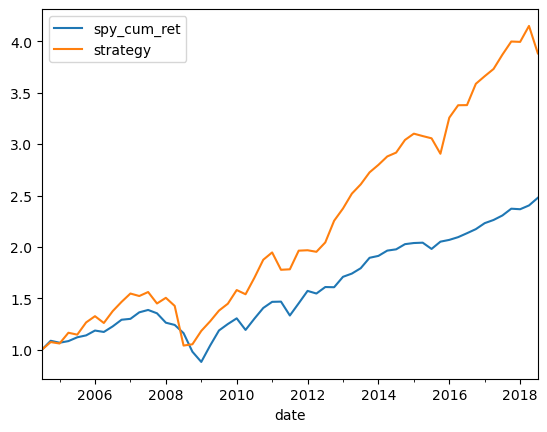

In [41]:

scalers = [StandardScaler() for i in range(len(start_dates) - 1)]

opt_training_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][selected_features_RF].values), columns=selected_features_RF) for i
    in range(len(start_dates) - 1)]
opt_valid_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][selected_features_RF].values), columns=selected_features_RF) for i
    in range(len(start_dates) - 1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][selected_features_RF].values), columns=selected_features_RF)
                 for i in range(len(start_dates) - 1)]
x = [1]
ret = []

for i in range(len(start_dates) - 1):
    classifiers[i].fit(opt_training_data[i], training_labels[i])

    preds = classifiers[i].predict(opt_test_data[i])
    profit_i = (preds * test_frames[i]['next_period_return']).sum()
    ret.append(profit_i)
    num_names = len(opt_test_data[i])
    x.append(x[i] + (x[i] / num_names) * profit_i)
SPY = pd.read_pickle(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/course_files_export/Lecture 2/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x
SPY.plot();

In [42]:
calculate_max_drawdown(SPY['strategy'])

-0.7590080614260265

In [43]:
calculate_max_drawdown(SPY['spy_cum_ret'])

-0.644186245477079

<Axes: xlabel='date'>

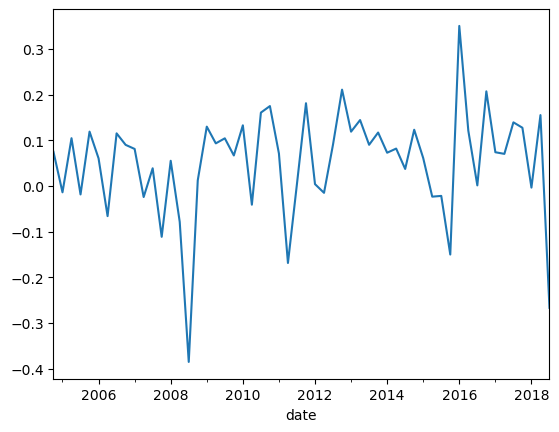

In [44]:
#this is the PL matrix
PL_data=SPY.diff()['strategy'].dropna()
PL_data.plot()

In [45]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret / strategy_std
print('Strategy Sharpe Ratio: ', strategy_sr)

Strategy Sharpe Ratio:  0.437125662855956


In [46]:
#this is the third strategy which only focus on mdd
Strategy_3=SPY['strategy']

Gradient Boost Strategy

In [10]:
raw_data = pd.read_pickle(
    r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/course_files_export/Lecture 3, Jan 11,2024/dataset.pkl')

raw_data.head()
data = raw_data[raw_data['market_cap'] > 1000.0]
data = data.copy()
data.fillna(0.0, inplace=True)


#label function
def f(x):
    if x > 0.01:
        return 1
    elif x < -0.025:
        return -1
    else:

        return 0


data['rel_performance'] = data['pred_rel_return'].apply(f)
data.reset_index(inplace=True)
data.set_index('date', inplace=True)
start_dates = [pd.to_datetime('2001-01-01') + pd.DateOffset(months=3 * i) for i in range(57)]
end_dates = [d + pd.DateOffset(months=36) for d in start_dates]
training_frames = [data.loc[d:d + pd.DateOffset(months=36)] for d in start_dates]
valid_frames = [data.loc[d + pd.DateOffset(months=3):d + pd.DateOffset(months=6)] for d in end_dates]
test_frames = [data.loc[d + pd.DateOffset(months=9):d + pd.DateOffset(months=12)] for d in end_dates]
training_data = [d.reset_index().drop
                 (['ticker', 'date',
                   'next_period_return',
                   'spy_next_period_return',
                   'rel_performance', 'pred_rel_return',
                   'return', 'cum_ret', 'spy_cum_ret'], axis=1) for d in training_frames]
valid_data = [d.reset_index().drop
              (['ticker', 'date',
                'next_period_return',
                'spy_next_period_return',
                'rel_performance', 'pred_rel_return',
                'return', 'cum_ret', 'spy_cum_ret'], axis=1) for d in valid_frames]
test_data = [d.reset_index().drop(['ticker', 'date',
                                   'next_period_return',
                                   'spy_next_period_return',
                                   'rel_performance', 'pred_rel_return',
                                   'return', 'cum_ret', 'spy_cum_ret'], axis=1) for d in test_frames]
training_data = [d[selected_features_GB] for d in training_data]
valid_data = [d[selected_features_GB] for d in valid_data]
test_data = [d[selected_features_GB] for d in test_data]
training_labels = [d['rel_performance'].values for d in training_frames]
valid_labels = [d['rel_performance'].values for d in valid_frames]
for i in range(len(start_dates) - 1):
    float_vars = [x for x in training_data[i].columns if data[x].dtype == 'float64']

    scaler = StandardScaler()
    training_data[i] = training_data[i].copy()
    valid_data[i] = valid_data[i].copy()
    test_data[i] = test_data[i].copy()
    training_data[i][float_vars] = scaler.fit_transform(training_data[i][float_vars])
    valid_data[i][float_vars] = scaler.transform(valid_data[i][float_vars])
    test_data[i][float_vars] = scaler.transform(test_data[i][float_vars])



In [11]:
#this takes way too long time to run
def objective(trial:Trial,train=None,labels=None,val=None,val_labels=None,val_rets=None):
    
    params = {
        "objective": "multiclass",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "n_estimators":trial.suggest_int('n_estimators',10,80,step=10),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 5, 25),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',400,2400,step=400),
        'learning_rate': trial.suggest_float('learning_rate',0.02,0.2,step=0.02)
    }
    
    gb_clf = LGBMClassifier(**params)
    gbm = gb_clf.fit(train,labels)
    preds = gbm.predict(val)
    profit = (preds*val_rets).sum()
    return profit


In [ ]:
optimal_hyperparameters = []
for i in range(len(start_dates) - 1):
    study = optuna.create_study(direction="maximize")

    study.optimize(partial(objective,
                           train=training_data[i],
                           labels=training_labels[i],
                           val=valid_data[i],
                           val_labels=valid_labels[i],
                           val_rets=valid_frames[i]['next_period_return']), n_trials=25, n_jobs=-1)

    optimal_hyperparameters.append(study.best_params)
    print(study.best_params)

[I 2024-03-03 19:11:30,761] A new study created in memory with name: no-name-0f5e0f97-8249-4b71-9e88-841c5844779a


In [ ]:
with open(r'optimal_hyperparameters_gb_01.pkl', 'wb') as f:
    pickle.dump(optimal_hyperparameters, f)
with open(r'optimal_hyperparameters_gb_01.pkl', 'rb') as f:
    optimal_hyperparameters = cPickle.load(f)
classifiers = []
for hyp_par in optimal_hyperparameters:
    gb_clf = LGBMClassifier(**hyp_par)
    classifiers.append(gb_clf)
for i in range(len(start_dates) - 1):
    classifiers[i].fit(training_data[i], training_labels[i])
with open(r'classifiers_gb_clf_01.pkl', 'wb') as f:
    pickle.dump(classifiers, f)
with open(r'classifiers_gb_clf_01.pkl', 'rb') as f:
    classifiers = cPickle.load(f)

In [ ]:
scalers = [StandardScaler() for i in range(len(start_dates)-1)]
           
opt_training_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][selected_features_GB].values), columns=selected_features_GB) for i
    in range(len(start_dates) - 1)]
opt_valid_data = [
    pd.DataFrame(scalers[i].fit_transform(training_frames[i][selected_features_GB].values), columns=selected_features_GB) for i
    in range(len(start_dates) - 1)]
opt_test_data = [pd.DataFrame(scalers[i].transform(test_frames[i][selected_features_GB].values), columns=selected_features_GB)
                 for i in range(len(start_dates) - 1)]

In [ ]:
x = [1]
ret = []

for i in range(len(start_dates)-1):
        
        classifiers[i].fit(opt_training_data[i],training_labels[i])

        preds = classifiers[i].predict(opt_test_data[i])
        profit_i = (preds*test_frames[i]['next_period_return']).sum()
        ret.append(profit_i)
        num_names = len(opt_test_data[i])
        x.append(x[i] + (x[i]/num_names)*profit_i)

In [ ]:
SPY = pd.read_pickle(r'/Users/zhihongqiu/Downloads/Simon-Chicago/CHICAGO/Machine Learning/course_files_export/Lecture 2/SPY_cum_ret.pkl')
SPY = SPY.loc['2004-09-01':'2018-09-30']
SPY = SPY.resample('Q').ffill()
SPY['spy_cum_ret'] = (SPY['spy_cum_ret'] - SPY['spy_cum_ret'][0] + 1)
SPY['strategy'] = x
SPY.plot();

In [ ]:
calculate_max_drawdown(SPY['strategy'])


In [ ]:
#this is the PL matrix
PL_data = SPY.diff()['strategy'].dropna()
PL_data.plot()

In [ ]:
strategy_mean_ret = (SPY['strategy'] - 1).diff().mean()
strategy_std = (SPY['strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret / strategy_std
print('Strategy Sharpe Ratio: ', strategy_sr)

In [ ]:
#this is the second strategy which only focus on mdd
Strategy_4=SPY['strategy']

Q2 - finding best combination

In [ ]:
#combine the 4 strategy to get the best sharp ratio, notice the first is only about profit, second is mdd, third is only about accuracy, the fourth strategy is just SPY
combined_strategy=pd.DataFrame()
combined_strategy['strategy_1']=Strategy_1
combined_strategy['strategy_2']=Strategy_2
combined_strategy['strategy_3']=Strategy_3
combined_strategy['strategy_4']=Strategy_4
combined_strategy['SPY']=SPY['spy_cum_ret']
combined_strategy=combined_strategy.dropna()
combined_strategy

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize

In [ ]:
def sharpe_ratio(weights, returns):
    weighted_returns = returns.dot(weights)
    mean_return = weighted_returns.mean()
    std_return = weighted_returns.std()
    sharpe_ratio = mean_return / std_return
    return -sharpe_ratio 

In [ ]:
# Step 2: Initial Guess and Bounds
num_assets = 5  # Strategy 1, 2, 3, and SPY
initial_guess = np.array([1.0 / num_assets] * num_assets)
bounds = tuple((-1, 1) for _ in range(num_assets)) # here I dont want to use really risky strategy

In [ ]:
# Step 3: Constraints
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})


In [ ]:
# Using daily returns for the optimization
daily_returns = (combined_strategy-1).diff().dropna()


In [ ]:
# Step 4: Run the Optimization
opt_results = minimize(sharpe_ratio, initial_guess, args=(daily_returns,), method='SLSQP', bounds=bounds, constraints=constraints)

# Display the optimal weights
optimal_weights = opt_results.x
print('Optimal Weights:', optimal_weights)


In [ ]:
combined_strategy=combined_strategy*optimal_weights
combined_strategy['combined_strategy']=combined_strategy['strategy_1']+combined_strategy['strategy_2']+combined_strategy['strategy_3']+combined_strategy['SPY']
combined_strategy['combined_strategy']

In [ ]:
strategy_mean_ret = (combined_strategy['combined_strategy'] - 1).diff().mean()
strategy_std = (combined_strategy['combined_strategy'] - 1).diff().std()
strategy_sr = strategy_mean_ret / strategy_std
print('Combined Strategy Sharpe Ratio: ', strategy_sr)